# Análise Exploratória de Dados - Detecção de Pneumonia (PyTorch)

Este notebook realiza a análise exploratória do dataset de Raios-X de Tórax, investigando o balanceamento das classes, visualizando amostras e analisando a distribuição de intensidade dos pixels, utilizando PyTorch.

In [1]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
from PIL import Image
import pandas as pd

# Adicionar diretório raiz ao path para importar src
sys.path.append(os.path.abspath('..'))

from src.dataset_loader import get_dataloaders

## 1. Carregamento dos Dados

Vamos definir os caminhos e carregar os dataloaders do PyTorch.

In [2]:
DATA_DIR = '../data/raw/chest_xray/chest_xray'

# Verificar se os diretórios existem
if not os.path.exists(DATA_DIR):
    print(f"ERRO: Diretório de dados não encontrado em {DATA_DIR}")
    print("Certifique-se de ter executado o script scripts/download_data.py ou ajustado o caminho.")
else:
    print("Diretório de dados encontrado.")

# Carregar Dataloaders
dataloaders, dataset_sizes, class_names = get_dataloaders(DATA_DIR, batch_size=32)
print(f"Classes: {class_names}")
print(f"Tamanhos dos datasets: {dataset_sizes}")

Diretório de dados encontrado.
Classes: ['NORMAL', 'PNEUMONIA']
Tamanhos dos datasets: {'train': 5216, 'val': 16, 'test': 624}


## 2. Distribuição das Classes

Verificamos o balanceamento entre casos Normais e de Pneumonia nos conjuntos de treino, teste e validação.

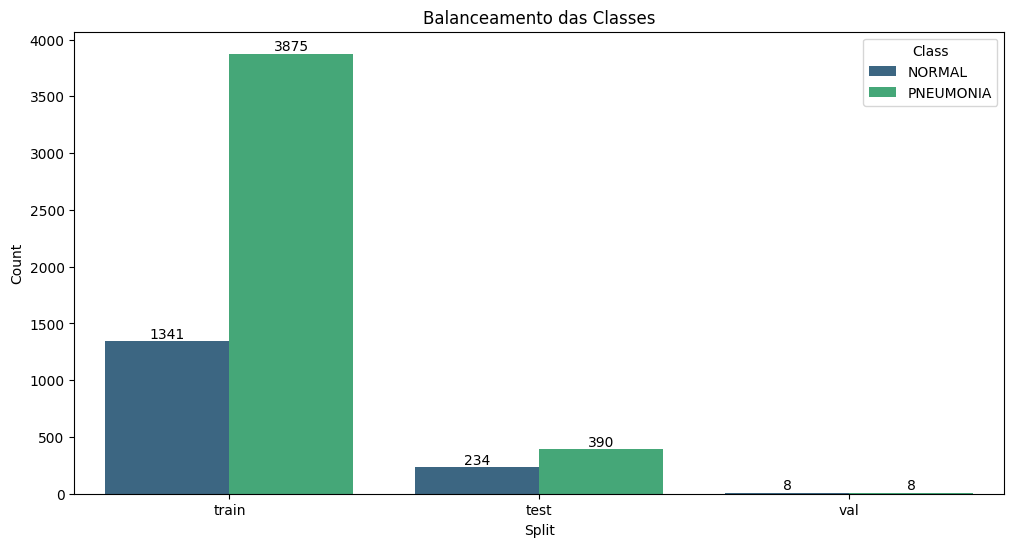

In [3]:
def plot_class_balance(data_dir):
    splits = ['train', 'test', 'val']
    # Assumindo a estrutura padrão do dataset
    classes = ['NORMAL', 'PNEUMONIA']
    
    data = []
    for split in splits:
        for cls in classes:
            path = os.path.join(data_dir, split, cls)
            if os.path.exists(path):
                count = len(os.listdir(path))
                data.append({'Split': split, 'Class': cls, 'Count': count})
    
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='Split', y='Count', hue='Class', palette='viridis')
    plt.title('Balanceamento das Classes')
    
    # Adicionar labels
    for container in plt.gca().containers:
        plt.gca().bar_label(container)
        
    plt.show()

if os.path.exists(DATA_DIR):
    plot_class_balance(DATA_DIR)

**Análise:** É comum haver um desbalanceamento, com mais casos de Pneumonia do que Normais. Isso pode ser tratado com pesos na Loss Function (WeightedRandomSampler ou pos_weight na BCEWithLogitsLoss).

## 3. Visualização de Amostras

Vamos visualizar algumas imagens do conjunto de treino para entender a variabilidade e a qualidade dos raios-X. As imagens já estão transformadas (resize, tensor, normalize).

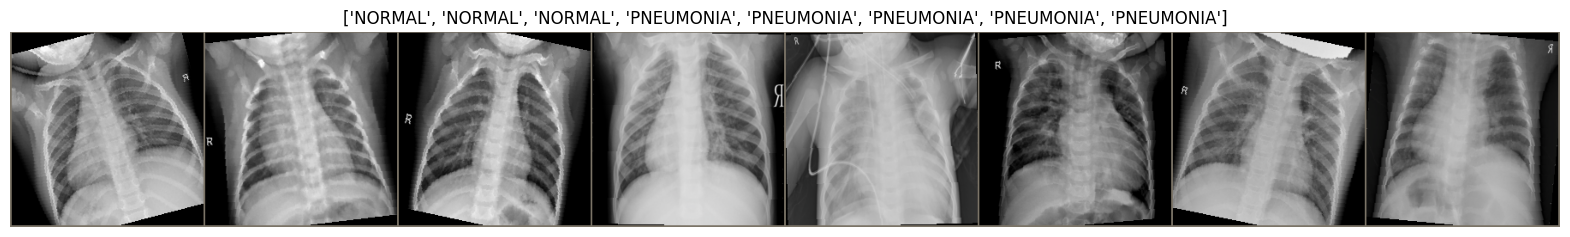

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch (visualizar 8 imagens)
num_images = 8
out = make_grid(inputs[:num_images])

plt.figure(figsize=(20, 10))
imshow(out, title=[class_names[x] for x in classes[:num_images]])
plt.show()

## 4. Análise de Intensidade de Pixel

Comparação dos histogramas de intensidade de pixel entre as classes.

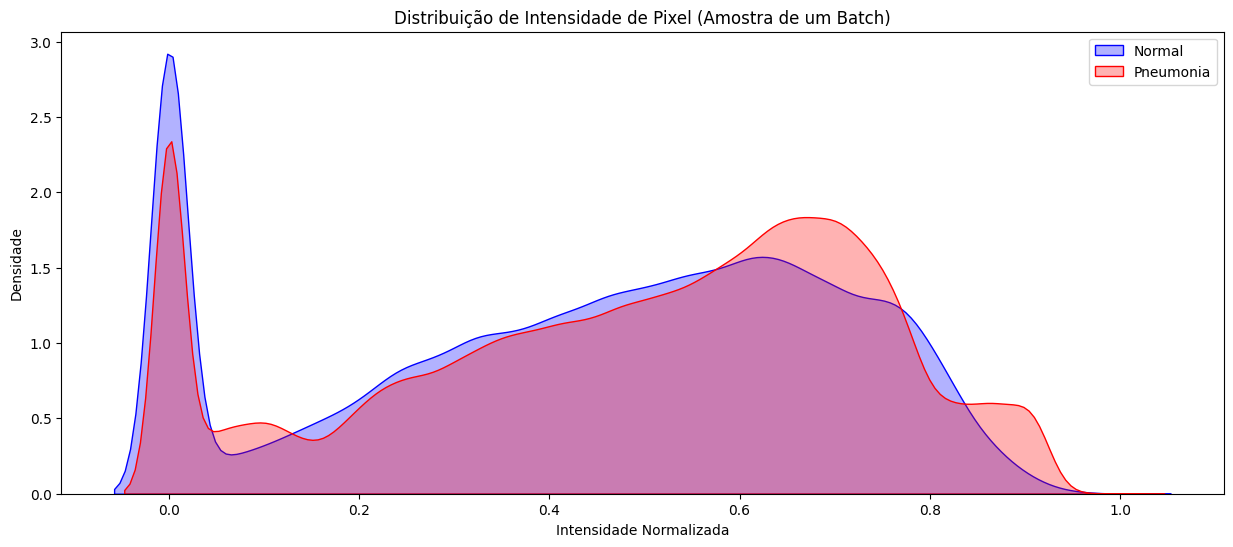

In [5]:
def plot_pixel_intensity(dataloader):
    normal_pixels = []
    pneumonia_pixels = []
    
    # Analisar apenas um batch para não demorar muito
    images, labels = next(iter(dataloader))
    
    for img, label in zip(images, labels):
        # Denormalize just to see original intensities roughly
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Converter para escala de cinza aproximada para histograma (média dos canais)
        gray_img = img.mean(axis=2)
        
        if class_names[label] == 'NORMAL':
            normal_pixels.extend(gray_img.ravel())
        else:
            pneumonia_pixels.extend(gray_img.ravel())
            
    plt.figure(figsize=(15, 6))
    
    sns.kdeplot(normal_pixels, color='blue', label='Normal', fill=True, alpha=0.3)
    sns.kdeplot(pneumonia_pixels, color='red', label='Pneumonia', fill=True, alpha=0.3)
    
    plt.title('Distribuição de Intensidade de Pixel (Amostra de um Batch)')
    plt.xlabel('Intensidade Normalizada')
    plt.ylabel('Densidade')
    plt.legend()
    plt.show()

plot_pixel_intensity(dataloaders['train'])

## 5. Análise de Dimensões das Imagens Originais

Verificar a variabilidade dos tamanhos das imagens originais antes do resize.

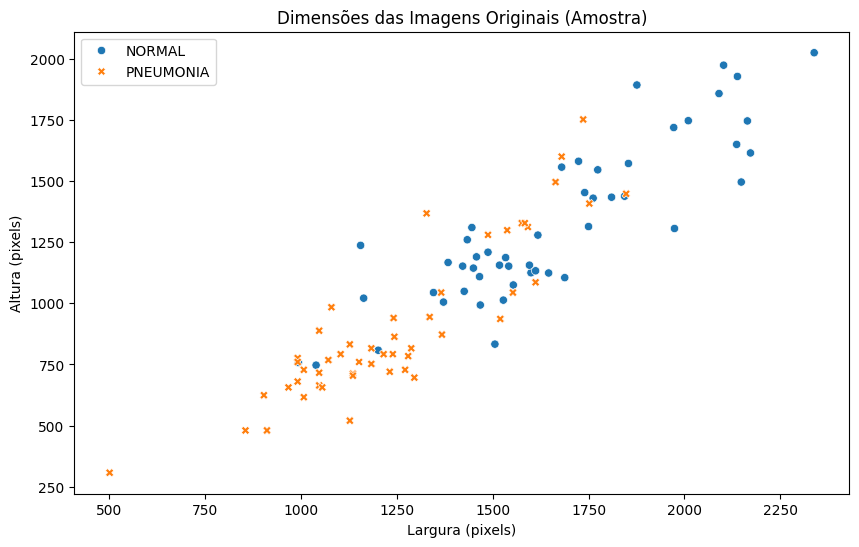

In [6]:
def plot_image_dimensions(data_dir):
    widths = []
    heights = []
    classes_list = []
    
    # Amostrar algumas imagens de treino (50 de cada classe)
    train_dir = os.path.join(data_dir, 'train')
    if not os.path.exists(train_dir):
        return

    for cls in ['NORMAL', 'PNEUMONIA']:
        path = os.path.join(train_dir, cls)
        if not os.path.exists(path): continue
            
        files = os.listdir(path)[:50]
        for f in files:
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    with Image.open(os.path.join(path, f)) as img:
                        w, h = img.size
                        widths.append(w)
                        heights.append(h)
                        classes_list.append(cls)
                except:
                    pass
                
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=widths, y=heights, hue=classes_list, style=classes_list)
    plt.title('Dimensões das Imagens Originais (Amostra)')
    plt.xlabel('Largura (pixels)')
    plt.ylabel('Altura (pixels)')
    plt.show()

if os.path.exists(DATA_DIR):
    plot_image_dimensions(DATA_DIR)